In [18]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_context('paper', font_scale=1.6)

In [2]:
def get_data(df, features=[]):
    xs = {}
    encoder = CountVectorizer(analyzer='char', lowercase=False)
    xs['Counts'] = encoder.fit_transform(df.peptide.values).toarray()
    xs['Binary'] = np.where(xs['Counts']>0, 1, 0)
    xs['Relative'] = xs['Counts'] / xs['Counts'].sum(1, keepdims=True)
    
    embeds_path = '../Data/Embeds/'
    for name, file in (('Doc2Vec', 'from_model_3_1.pkl'), ('Bert', 'bert_embeds.pkl')):
        embeds = df.peptide.map(pickle.load(open(embeds_path+file, 'rb'))).values
        xs[name] = np.vstack(embeds)
    
    if features:
        x_meta = df[features].values.reshape(-1, len(features))
        for key, x in xs.items():
            xs[key] = np.hstack([x, x_meta])
        xs['Meta'] = x_meta

    y = df.reproducibility.values
    groups = LabelEncoder().fit_transform(df['protein_id'].values)
    features =  list(encoder.get_feature_names()) + features
    return xs, y, groups, features 

In [3]:
df = pd.read_csv('../Data/reproducibility.csv').sample(frac=1, random_state=1).reset_index(drop=True)
df.head()

,peptide,peptide_aromaticity,peptide_gravy,peptide_helix,peptide_instability_index,peptide_isoelectric_point,peptide_len,peptide_log_len,peptide_log_weight,peptide_mean,...,protein_len,protein_log_len,protein_log_weight,protein_molar_extinction_coefficient,protein_sheet,protein_turn,protein_weight,reproducibility,reproducibility_corrected,peptide_detectability
0,SELTQQLNALFQDK,0.071429,-0.742857,0.285714,39.107143,4.368781,14,2.639057,7.399267,21.571060,...,480,6.173786,10.925809,14900.0,0.372917,0.162500,55592.8205,0.134116,-0.416929,0.863536
1,EETGQVLER,0.000000,-1.288889,0.222222,27.300000,4.252773,9,2.197225,6.966134,23.123484,...,613,6.418365,11.114425,114625.0,0.225122,0.295269,67132.6103,0.118270,-0.276561,0.539523
2,QLYGDTGVLGR,0.090909,-0.263636,0.363636,-20.009091,5.835682,11,2.397895,7.071824,22.152872,...,184,5.214936,9.929104,22982.5,0.288043,0.163043,20518.9427,0.730757,-0.019208,0.858968
3,EVQVFEITENSAK,0.076923,-0.415385,0.307692,33.061538,4.252773,13,2.564949,7.308954,18.674903,...,188,5.236442,9.948520,4470.0,0.218085,0.202128,20921.2417,0.245870,0.106907,0.876252
4,EDYICYAR,0.250000,-0.662500,0.375000,62.425000,4.370430,8,2.079442,6.939377,23.851474,...,127,4.844187,9.523820,18450.0,0.188976,0.377953,13681.7806,0.768097,0.377618,0.649913


# Data distributions

Text(362.43863636363625, 0.5, 'Count')

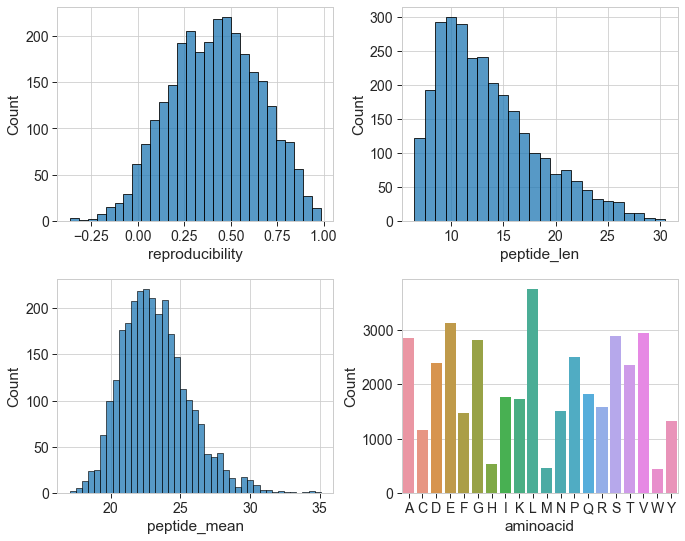

In [4]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
f.tight_layout(pad=2.0)
sns.histplot(data=df, x='reproducibility', ax=ax1)
sns.histplot(data=df, x='peptide_len', discrete=True, ax=ax2)
sns.histplot(data=df, x='peptide_mean', ax=ax3)

xs, _, _, aa_names = get_data(df)
aa_counts = xs['Counts'].sum(0)
sns.barplot(x=aa_names, y=aa_counts, ax=ax4)
ax4.set_xlabel('aminoacid')
ax4.set_ylabel('Count')

# plt.savefig('Plots/rep_data_dists.png', dpi=300, bbox_inches='tight')

Number of Proteins:  550


<AxesSubplot:xlabel='reproducibility', ylabel='protein_id'>

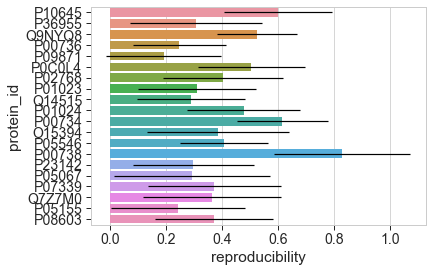

In [5]:
df2 = df[['reproducibility', 'protein_id']].groupby('protein_id').mean()
df2['count'] = df[['reproducibility', 'protein_id']].groupby('protein_id').count()
df2['std'] = df[['reproducibility', 'protein_id']].groupby('protein_id').std()
print('Number of Proteins: ', df2.shape[0])
df2 = df2[df2['count']>10]
df2 = df2.sample(frac=1).reset_index()
df2 = df2.iloc[:20]
sns.barplot(data=df2, y='protein_id', x='reproducibility', orient='h', xerr=df2['std'])
# plt.savefig('Plots/protein_reproducibility.jpg', dpi=300, bbox_inches='tight')

# Embeddings

<AxesSubplot:title={'center':'Bert Embeddings'}>

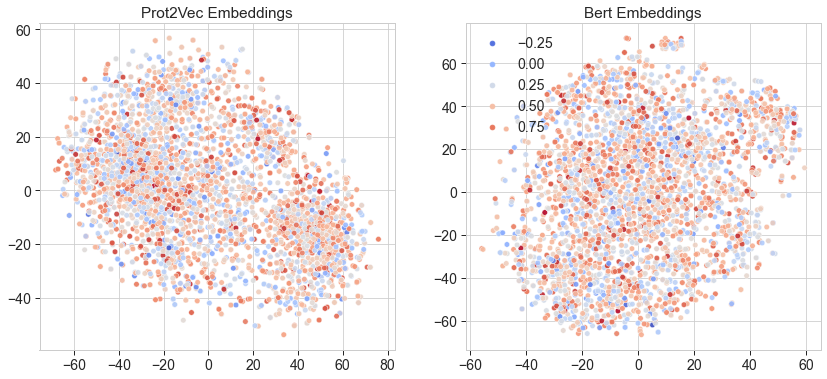

In [30]:
xs, y, _, _ = get_data(df)
y = y.flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_title('Prot2Vec Embeddings')
ex, ey = TSNE(n_components=2).fit_transform(xs['Doc2Vec']).T
sns.scatterplot(x=ex, y=ey, hue=y, palette='coolwarm', s=30, alpha=0.9, ax=ax1)
ax1.get_legend().remove()

ax2.set_title('Bert Embeddings')
ex, ey = TSNE(n_components=2).fit_transform(xs['Bert']).T
sns.scatterplot(x=ex, y=ey, hue=y, palette='coolwarm', s=30, alpha=0.9, ax=ax2)

# plt.savefig('Plots/reproducibility_embeddings.jpg', dpi=300, bbox_inches='tight')

# Optimization Results

In [7]:
def plot_optimization(df, log_idxs=[]):
    g = sns.PairGrid(df)
    for idx in log_idxs:
        for i in range(len(g.axes)):
            g.axes[i, idx].set_xscale('log', base=2)
            g.axes[idx, i].set_yscale('log', base=2)
    g.map_diag(sns.histplot)
    g.map_upper(sns.scatterplot, hue=r_df['loss'], palette='vlag')
    g.map_lower(sns.histplot)
    g.map_lower(sns.kdeplot, levels=4, color='0.2')
    g.axes[0, -1].legend(loc='best', bbox_to_anchor=(1, 1), title='loss')
    return g

def optim_history2df(results):
    r_df = pd.DataFrame(results['optim_history'][0])
    for i in range(1, len(results['optim_history'])):
        r_df = r_df.append(pd.DataFrame(results['optim_history'][i]))
    r_df.dropna(inplace=True)
    return r_df

def print_table(exp_names, comp_results, ci=False, precision=5):
    model_names = comp_results[exp_names[0]]['Model']
    lines = []
    lines.append('\\begin{table}[h]')
    lines.append('\\centering')
    lines.append('\\begin{tabular}{l' + '|l'*len(exp_names) + '}')
    lines.append('\\textbf{Model}' + ''.join([' & \\textbf{'+e+'}' for e in exp_names]) + ' \\\\ \\hline')
    lines += [model for model in model_names]
    for exp_name in exp_names:
        for i in range(len(model_names)):
            mse = comp_results[exp_name]['Test MSE'][i]
            if ci:
                std = comp_results[exp_name]['Test Std'][i]
                text = str(np.round(mse, precision)) + ' \\pm ' + str(np.round(std, precision))
            else:
                text = str(np.round(mse, precision))
            text = ' & ' + text
            lines[i+4] += text
    for i in range(len(model_names)-1):
        lines[i+4] += ' \\\\ \\hline'
    lines.append('\\end{tabular}')
    lines.append('\\caption{}')
    lines.append('\\label{}')
    lines.append('\\end{table}')
    lines = '\n'.join(lines)
    print(lines)

In [8]:
results = pickle.load(open('Results/reproducibility_results.pkl', 'rb'))['Counts']

In [9]:
pd.DataFrame(results['MLPRegressor']['params'])

,solver,learning_rate,alpha,batch_size,hidden_layer_sizes,learning_rate_init
0,sgd,adaptive,0.035282,8,32,0.004042
1,sgd,adaptive,0.022194,8,34,0.112244
2,sgd,adaptive,0.247322,36,168,0.041574
3,sgd,adaptive,0.175931,44,218,0.017041
4,sgd,adaptive,0.457534,132,34,0.024630


## KernelRidge

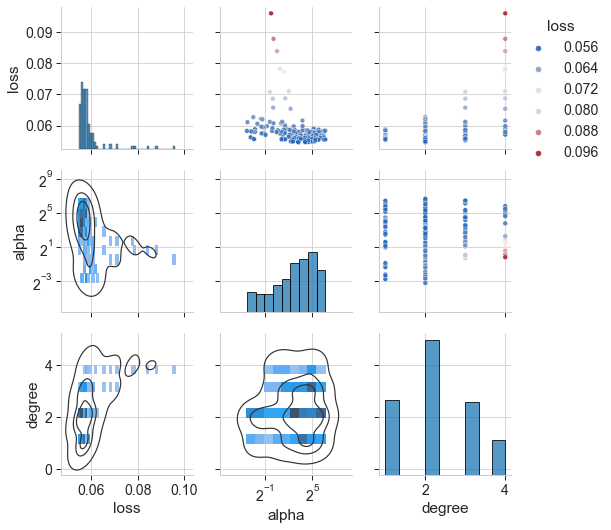

In [10]:
r_df = optim_history2df(results['KernelRidge'])
r_df = r_df[r_df['loss']<0.1]
plot_optimization(r_df, [1])
# plt.savefig('Plots/kr_optim_space.jpg', dpi=300, bbox_inches='tight')

## Random Forest

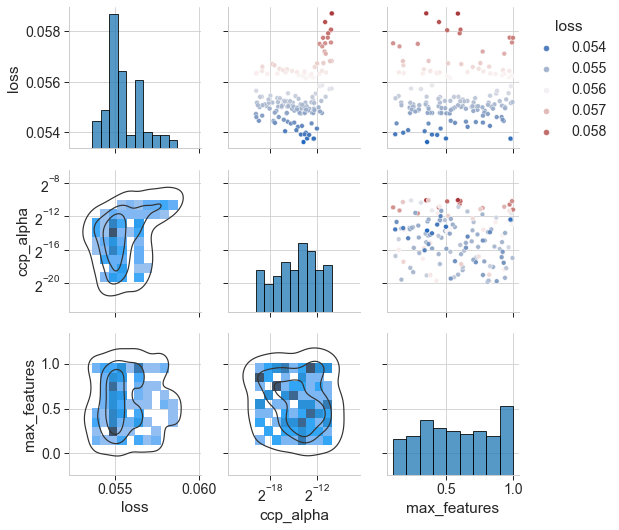

In [11]:
r_df = optim_history2df(results['RandomForestRegressor'])
r_df = r_df.drop('n_estimators', 1)
plot_optimization(r_df, [1])
# plt.savefig('Plots/rf_optim_space.jpg', dpi=300, bbox_inches='tight')

## MLPRegressor

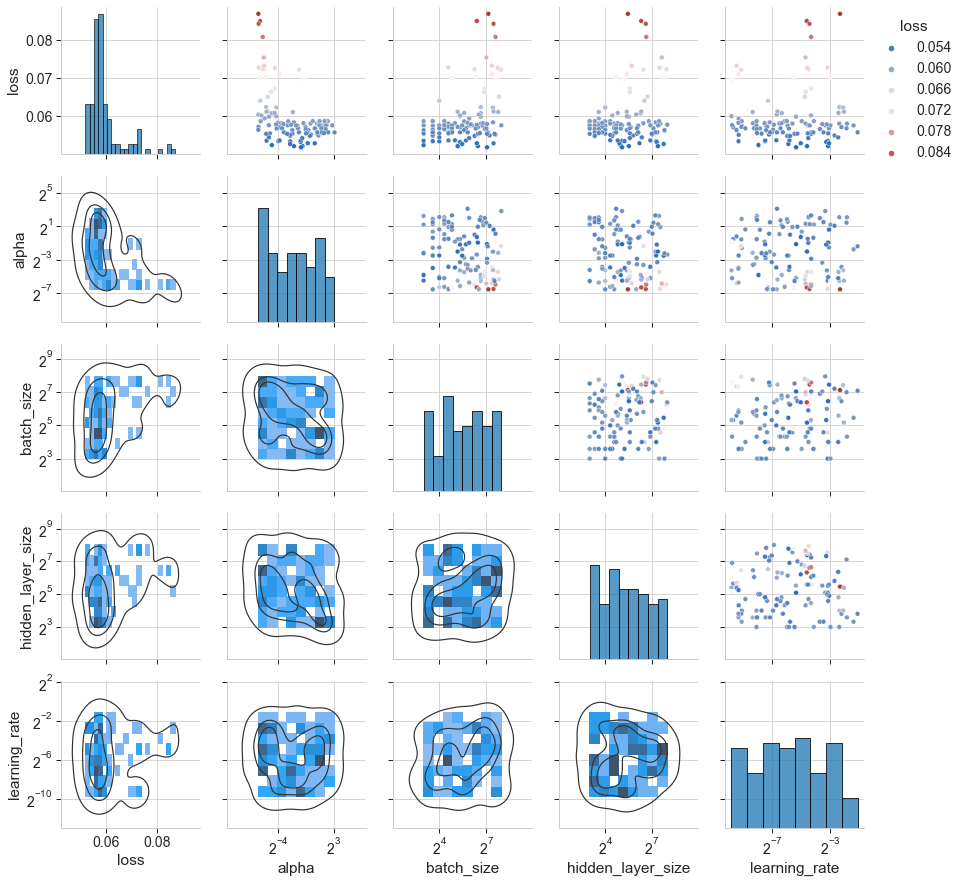

In [12]:
r_df = optim_history2df(results['MLPRegressor'])
r_df = r_df.drop('learning_rate', 1)
r_df = r_df.rename(columns={'hidden_layer_sizes': 'hidden_layer_size',
                            'learning_rate_init': 'learning_rate'})
plot_optimization(r_df, [1, 2, 3, 4])
# plt.savefig('Plots/mlp_optim_space.jpg', dpi=300, bbox_inches='tight')

## CNNGRU

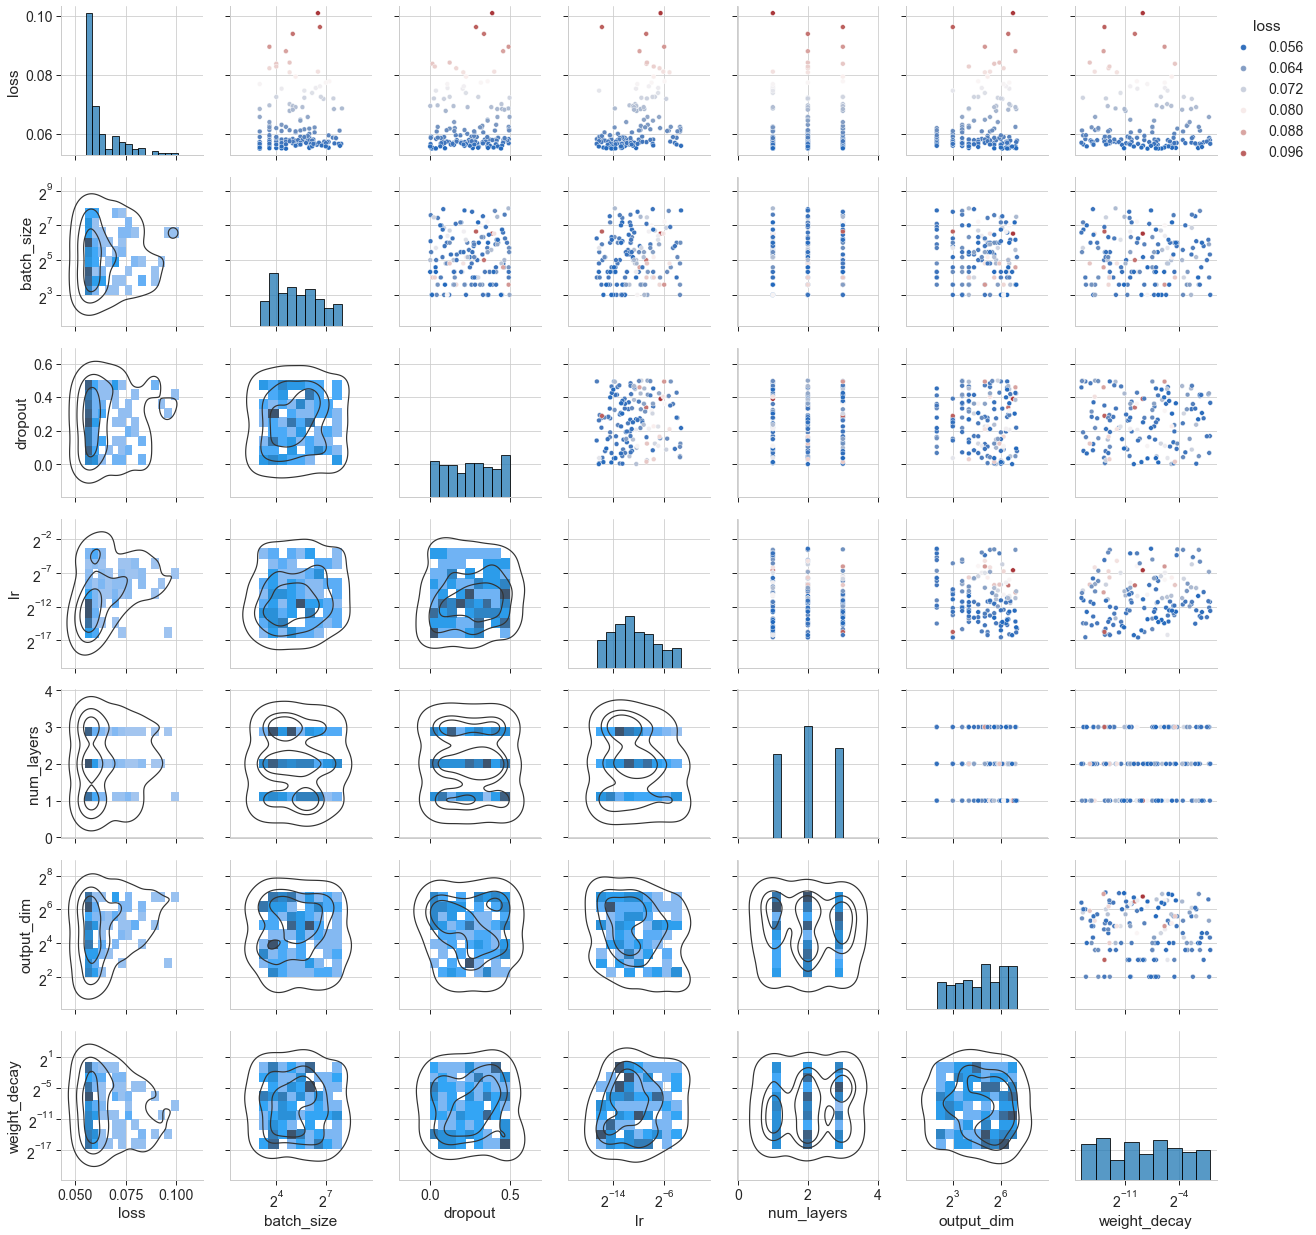

In [13]:
results =  pickle.load(open('Results/reproducibility_results.pkl', 'rb'))['Seq']

r_df = optim_history2df(results['CNNGRU'])
r_df = r_df[r_df['loss']<0.15]

plot_optimization(r_df, [1, 3, 5, 6])
# plt.savefig('Plots/cnngru_optim_space.jpg', dpi=300, bbox_inches='tight')

# Metrics

In [16]:
def results2df(results, exp_names, model_names, metric):
    d = defaultdict(list)
    d['Model'] =  model_names
    for model in model_names:
        for exp in exp_names:
            errors = results[exp][model]['results'][metric]
            mse = np.round(np.mean(errors), 5)
            std = np.round(np.std(errors), 5)
            d[exp].append(f'${mse} \pm {std}$')
    return pd.DataFrame(d)

def df2latex(df):
    rows, cols = df.shape
    lines = []
    lines.append('\\begin{table}[h]')
    lines.append('\\centering')
    lines.append('\\begin{tabular}{l' + '|c'*(cols-1) + '}')    
    lines.append(' & '.join([f'\\textbf{{{col}}}' for col in df]) + ' \\\\ \\hline')
    lines += [' & '.join(row) + ' \\\\ \\hline' for row in df.values]
    lines[-1] = lines[-1].replace(' \\\\ \\hline', '')
    lines.append('\\end{tabular}')
    lines.append('\\caption{}')
    lines.append('\\label{}')
    lines.append('\\end{table}')
    lines = '\n'.join(lines)
    print(lines)

In [21]:
results = pickle.load(open('Results/reproducibility_results.pkl', 'rb'))
results['Counts+Peptide']['Ensemble'] = {'results': pickle.load(open('Results/reproducibility_ensemble.pkl', 'rb'))['Counts+Peptide']}

model_names = ['KernelRidge', 'RandomForestRegressor', 'MLPRegressor']
metric = 'Test EV'

df_bow = results2df(
    results=results,
    exp_names=['Counts', 'Relative', 'Binary'],
    model_names=model_names,
    metric=metric
)

df_bowlen = results2df(
    results=results,
    exp_names=['Counts+len', 'Relative+len', 'Binary+len'],
    model_names=model_names,
    metric=metric
)

df_embeds = results2df(
    results=results,
    exp_names=['Doc2Vec', 'Bert'],
    model_names=model_names,
    metric=metric
)

df_seq = results2df(
    results=results,
    exp_names=['Seq'],
    model_names=['GRU', 'CNNGRU'],
    metric=metric
)

df_all = results2df(
    results=results,
    exp_names=['Counts', 'Peptide', 'Counts+Peptide'],
    model_names=model_names,
    metric=metric
)

df_ensemble = results2df(
    results=results,
    exp_names=['Counts+Peptide'],
    model_names=['Ensemble'],
    metric=metric
)

# df_bow
# df_bowlen
# df_embeds
# df_seq
df_all
# df_ensemble

,Model,Counts,Peptide,Counts+Peptide
0,KernelRidge,$0.03203 \pm 0.01724$,$0.11902 \pm 0.02066$,$0.11228 \pm 0.01739$
1,RandomForestRegressor,$0.04406 \pm 0.02145$,$0.13128 \pm 0.01051$,$0.1376 \pm 0.01615$
2,MLPRegressor,$0.09357 \pm 0.02322$,$0.12469 \pm 0.01596$,$0.13262 \pm 0.01741$


In [22]:
df2latex(df_all)

\begin{table}[h]
\centering
\begin{tabular}{l|c|c|c}
\textbf{Model} & \textbf{Counts} & \textbf{Peptide} & \textbf{Counts+Peptide} \\ \hline
KernelRidge & $0.03203 \pm 0.01724$ & $0.11902 \pm 0.02066$ & $0.11228 \pm 0.01739$ \\ \hline
RandomForestRegressor & $0.04406 \pm 0.02145$ & $0.13128 \pm 0.01051$ & $0.1376 \pm 0.01615$ \\ \hline
MLPRegressor & $0.09357 \pm 0.02322$ & $0.12469 \pm 0.01596$ & $0.13262 \pm 0.01741$
\end{tabular}
\caption{}
\label{}
\end{table}


In [23]:
pd.DataFrame(results['Seq']['GRU']['params']).mean()

batch_size      24.800000
dropout          0.149090
lr               0.006252
num_layers       2.000000
output_dim      36.800000
weight_decay     0.381605
dtype: float64

# Feature Importances

In [24]:
def importance2df(results, model_mapping):
    d = {'Feature': [], 'Importance': [], 'Model': []}
    for model, model_name in model_mapping.items():
        for feature, importance in results[model].items():
            feature = feature.replace('peptide_rt', 'retention_time').replace('peptide_', '')
            d['Feature'] += [feature.replace('peptide_', '')] * len(importance)
            d['Importance'] += list(importance)
            d['Model'] += [model_name] * len(importance)
    return pd.DataFrame(d)

In [25]:
results = pickle.load(open('Results/reproducibility_feature_importances.pkl', 'rb'))
model_mapping = {
    'KernelRidge': 'KR',
    'RandomForestRegressor': 'RF',
    'MLPRegressor': 'ANN'
}

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

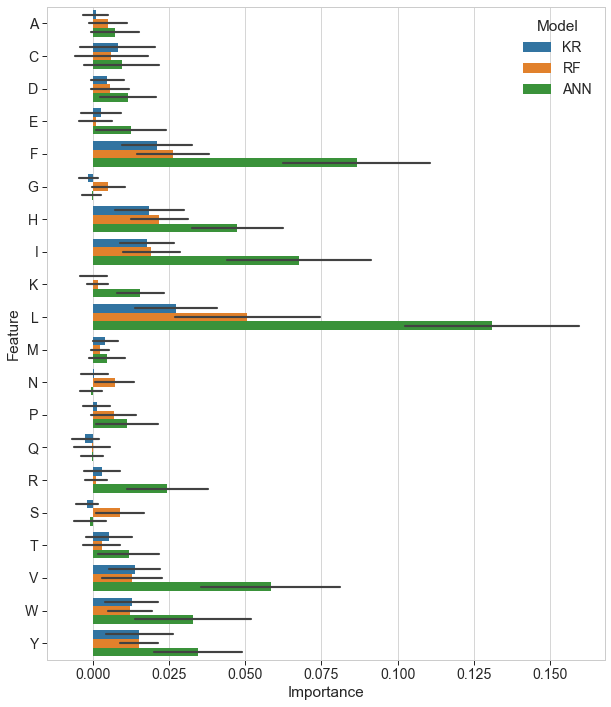

In [26]:
exp = 'Counts'

plt.figure(figsize=(10, 12))
d = importance2df(results[exp], model_mapping)
sns.barplot(data=d, x='Importance', y='Feature', orient='h', hue='Model', ci='sd')
# plt.savefig('Plots/counts_importances.jpg', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

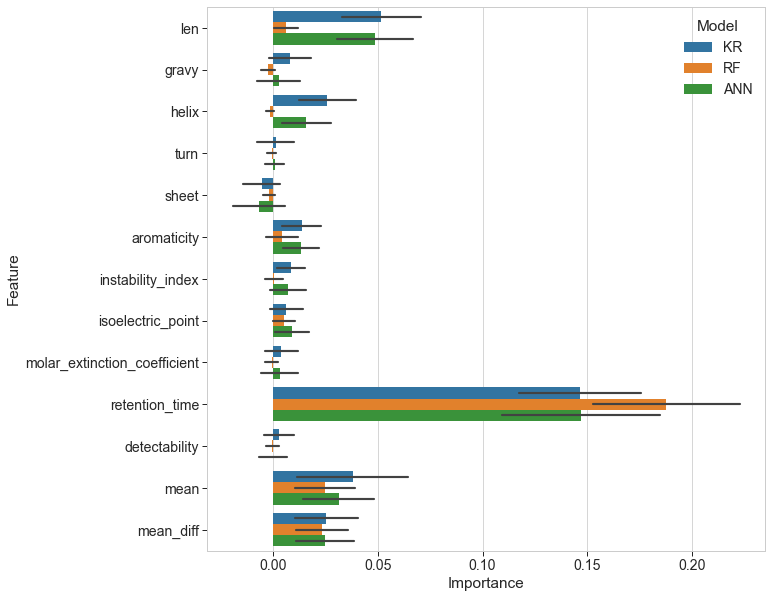

In [27]:
exp = 'Peptide'

plt.figure(figsize=(10, 10))
d = importance2df(results[exp], model_mapping)
sns.barplot(data=d, x='Importance', y='Feature', orient='h', hue='Model', ci='sd')
# plt.savefig('Plots/peptide_importances.jpg', dpi=300, bbox_inches='tight')

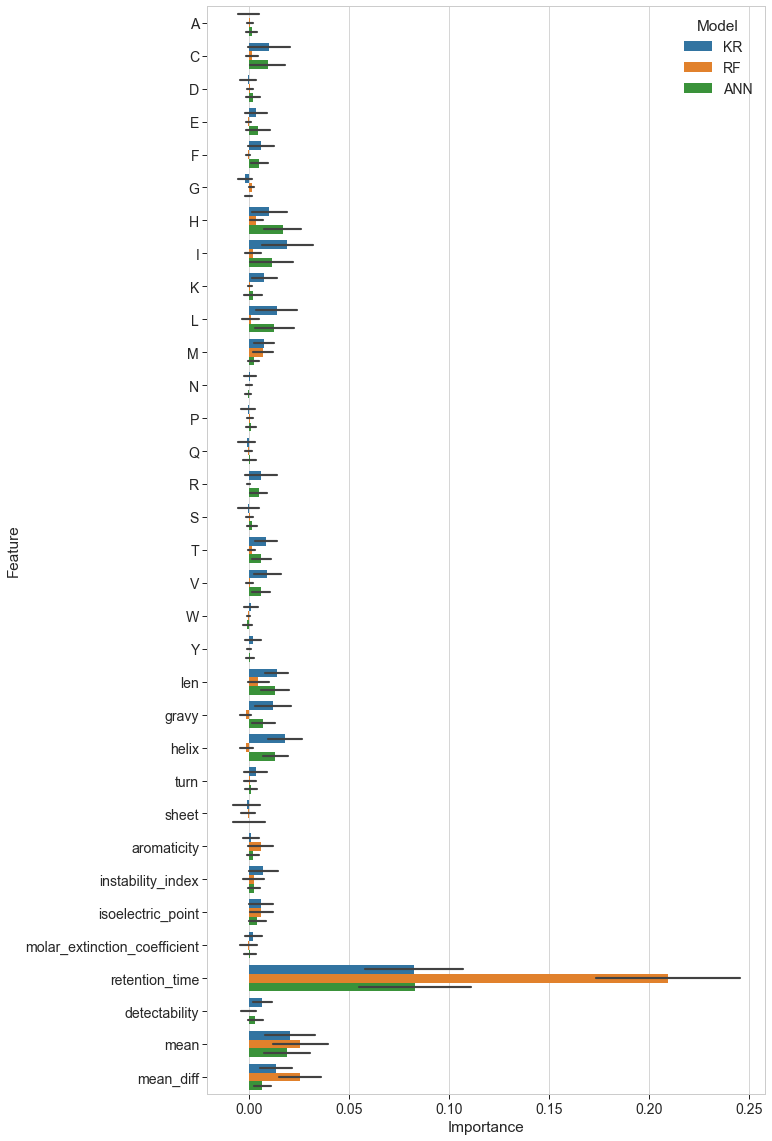

In [28]:
exp = 'Counts+Peptide'

plt.figure(figsize=(10, 20))
d = importance2df(results[exp], model_mapping)
g = sns.barplot(data=d, x='Importance', y='Feature', orient='h', hue='Model', ci='sd')
plt.savefig('Plots/countspeptide_importances.jpg', dpi=300, bbox_inches='tight')

## Retenion Time

Text(0.5, 0, 'retention time [min]')

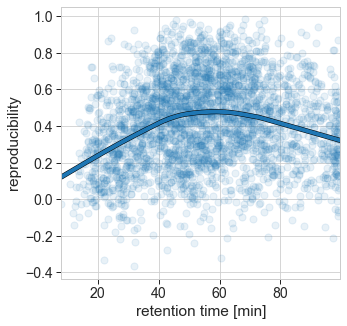

In [29]:
plt.figure(figsize=(5, 5))
sns.regplot(data=df, x='peptide_rt', y='reproducibility', lowess=True, scatter=False, color='black',
            line_kws={'linewidth':5})
sns.regplot(data=df, x='peptide_rt', y='reproducibility', lowess=True, color=None,
            scatter_kws={'marker':'o', 's':50, 'alpha':0.1},
            line_kws={'linewidth':4})

plt.xlabel('retention time [min]')
# plt.savefig('Plots/rep_vs_rt.jpg', dpi=300, bbox_inches='tight')